In [ ]:
import hydra
from omegaconf import OmegaConf

hydra.initialize(config_path="../configs")

# Load the config file
cfg = hydra.compose(config_name="config")

# # Print config as YAML
# config = OmegaConf.to_yaml(cfg)




/tmp/ipykernel_728797/3434187718.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="../configs")


In [2]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

# Now, you can import the module
import diffusion

import utils
import math

/root/miniconda3/envs/mdm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
cfg.eval.checkpoint_path = '/nfs/mtr/code/ddit-c2i/outputs/ddit-gitmodel-linear-bs1024-m1024/03-08-142357/checkpoints/1-20000.ckpt'
cfg.mask_vocab_size = 1024
cfg.lm_vocab_size = 16384
cfg.mode = 'eval'


In [48]:

def _load_from_checkpoint(config):
    
    return diffusion.Diffusion.load_from_checkpoint(
        config.eval.checkpoint_path,
        config=config,
        strict=False)


model = _load_from_checkpoint(config=cfg)
model = model.to('cuda:0')
for p in model.parameters():
    p.requires_grad = False




/root/miniconda3/envs/mdm/lib/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Current state = eval, set to eval mode.
RepA disabled, skip loading.


/root/miniconda3/envs/mdm/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['backbone.projectors.0.0.weight', 'backbone.projectors.0.0.bias', 'backbone.projectors.0.2.weight', 'backbone.projectors.0.2.bias', 'backbone.projectors.0.4.weight', 'backbone.projectors.0.4.bias']


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import torch

In [61]:
def generate_clustered_points(num_points=100, num_clusters=100, embedding_dim=768, cluster_std=5.0):
    """Generate synthetic data with clusters in a high-dimensional space."""
    np.random.seed(42)
    cluster_centers = np.random.randn(num_clusters, embedding_dim) * 20  # Spread out clusters
    points = []
    for _ in range(num_points):
        cluster = np.random.randint(0, num_clusters)
        point = cluster_centers[cluster] + np.random.randn(embedding_dim) * cluster_std
        points.append(point)
    return np.array(points)

points = generate_clustered_points()

In [49]:
num_tokens = 16384 + 1024
embeddings = model.backbone.vocab_embed(np.arange(num_tokens))  # Shape: (17408, embedding_dim)
embeddings = embeddings.cpu().float().numpy()


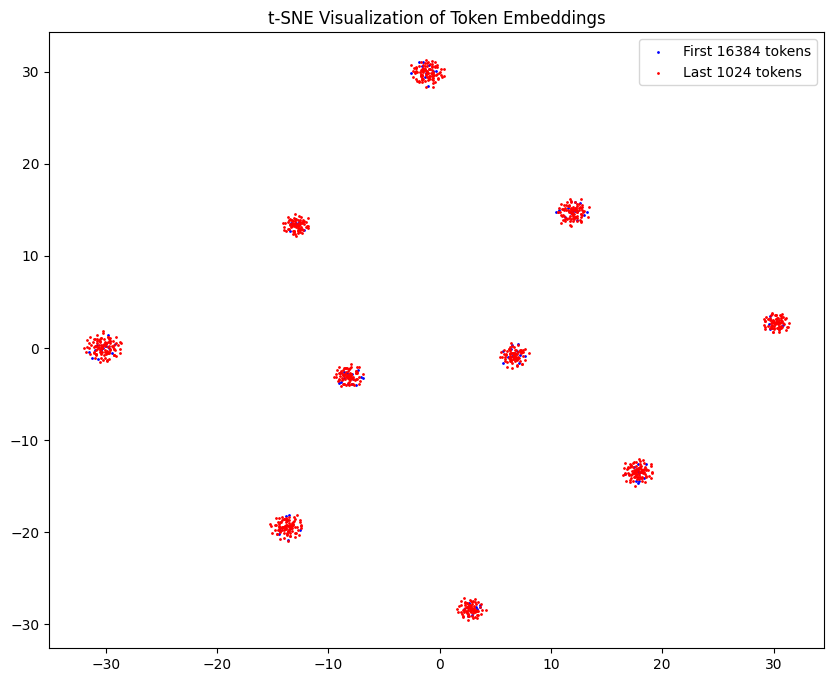

In [54]:
# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
reduced_embeddings = tsne.fit_transform(points)

# Plot first 16384 tokens in blue, last 1024 tokens in red
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:100, 0], reduced_embeddings[:100, 1], s=1, color='blue', label='First 16384 tokens')
plt.scatter(reduced_embeddings[100:, 0], reduced_embeddings[100:, 1], s=1, color='red', label='Last 1024 tokens')
plt.legend()
plt.title("t-SNE Visualization of Token Embeddings")
plt.show()

In [62]:
test = np.concatenate((embeddings, points))

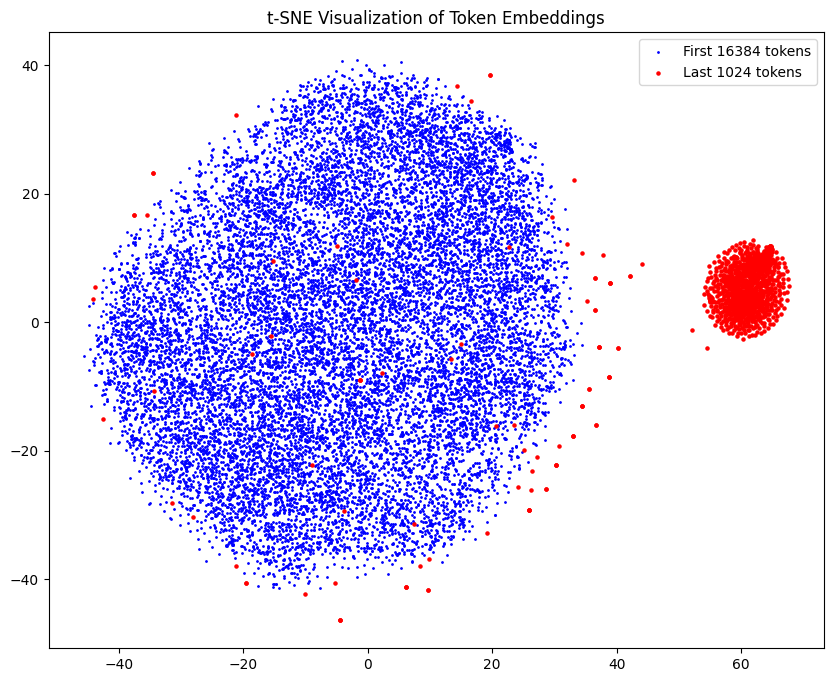

: 

In [ ]:
# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
reduced_embeddings = tsne.fit_transform(test)

# Plot first 16384 tokens in blue, last 1024 tokens in red
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:16384, 0], reduced_embeddings[:16384, 1], s=1, color='blue', label='First 16384 tokens')
plt.scatter(reduced_embeddings[16384:, 0], reduced_embeddings[16384:, 1], s=5, color='red', label='Last 1024 tokens')
plt.legend()
plt.title("t-SNE Visualization of Token Embeddings")
plt.show()

In [ ]:
tsne = TSNE(n_components=3, random_state=42, perplexity=50)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot first 16384 tokens in blue, last 1024 tokens in red
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_embeddings[:16384, 0], reduced_embeddings[:16384, 1], reduced_embeddings[:16384, 2], s=1, color='blue', label='First 16384 tokens')
ax.scatter(reduced_embeddings[16384:, 0], reduced_embeddings[16384:, 1], reduced_embeddings[16384:, 2], s=5, color='red', label='Last 1024 tokens')
ax.set_title("t-SNE 3D Visualization of Token Embeddings")
ax.legend()
plt.show()